# Alignment-based Metrics in Machine Learning

When learning from non-aligned time series, being able to use alignment-based
metrics at the core of Machine Learning (ML) systems is key.

## Classification

### Nearest Neighbors

First, the similarity measures presented in this chapter can be used in
conjunction with nearest-neighbor classifiers.
To do so, it suffices to compute DTW (or any other time-series-specific)
between a test time series $\mathbf{x}$ and all the series from the training
set, and then assign a label to $\mathbf{x}$ based on a voting strategy.

Note however that nearest neighbor searches in standard euclidean spaces are
usually fastened by smart indexing strategies that are no longer available when
using DTW in place of Euclidean distance.
A typical example is the use of triangular inequality to prune the set of
candidate neighbors (recall that DTW does not satisfy the triangular
inequality).

````{admonition} tslearn tip
:class: tip, dropdown

To use these metrics for $k$-Nearest-Neighbor classification in ``tslearn``,
the code is as follows:

```python
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
```

````

(sec:gak)=
### Global Alignment Kernel

Let us define the Global Alignment Kernel (GAK, {cite}`cuturi2007kernel`) as:

\begin{equation}
k_\text{GA}^\gamma(\mathbf{x}, \mathbf{x}^\prime) =
    \exp{- \frac{\text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)}{\gamma}}
\end{equation}

Though this kernel is not proved to be positive semi-definite (except in the
univariate case {cite}`blondelmensch2020`), authors claim
that, in practice, resulting Gram matrices happen to be psd in most of their
experiments, hence allowing this kernel to be used in standard kernel methods,
as discussed in the next section.
One typical use-case consists in using this kernel in Support
Vector Machines for classification.
When doing so, resulting support vectors are hence time series, as shown below:

In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.ion()

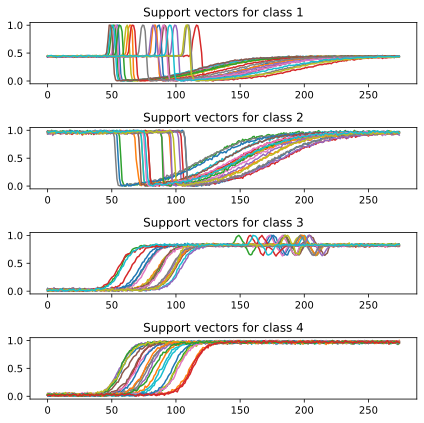

In [2]:
import numpy

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.svm import TimeSeriesSVC

numpy.random.seed(0)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

clf = TimeSeriesSVC(kernel="gak", gamma=.1)
clf.fit(X_train, y_train)

n_classes = len(set(y_train))

plt.figure(figsize=(6, 6))
support_vectors = clf.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title("Support vectors for class %d" % cl)
    for ts in support_vectors[i]:
        plt.plot(ts.ravel())

plt.tight_layout()

Note that methods presented in this section straight-forwardly extend to
regression setups in
which the target variable is not a time series itself (for this specific case,
refer to our {ref}`sec:forecasting` section).

## Clustering

As shown above in our {ref}`sec:intro_align` section, using standard clustering
algorithms can cause trouble when dealing with time-shifted time series.

In what follows, we discuss the use of Dynamic Time Warping at the core of
$k$-means clustering.

The $k$-means algorithm repeats the same two steps until convergence:

1. assign all samples to their closest centroid ;
2. update centroids as the barycenters of the samples assigned to their
associated cluster.

Step 1 only requires to compute distances.
Euclidean distance can hence
straight-forwardly be replaced by Dynamic Time Warping in order to get shift
invariance.
Step 2 requires the ability to compute barycenters.

These modifications allow to run a $k$-means algorithm with DTW as the core
metric:

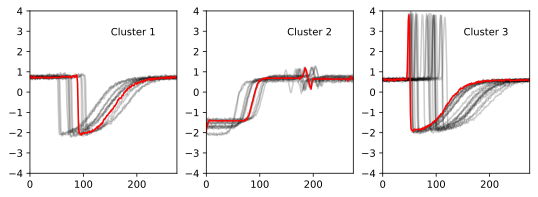

In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

seed = 0
numpy.random.seed(seed)

# Below is some data manipulation to make the dataset smaller
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
sz = X_train.shape[1]

# DBA-k-means
dba_km = TimeSeriesKMeans(n_clusters=3,
                          metric="dtw",
                          verbose=False,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

plt.figure(figsize=(9, 3))
for yi in range(3):
    plt.subplot(1, 3, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

As a result, clusters gather time series of similar shapes, which is due to the
ability of Dynamic Time Warping (DTW) to deal with time shifts, as explained
above.
Second, cluster centers (aka centroids) are computed as the barycenters
with respect to DTW, hence
they allow to retrieve a sensible average shape whatever the temporal shifts
in the cluster.

Another option to deal with such time shifts is to rely on the kernel trick.
Indeed, the kernel $k$-means algorithm {cite}`dhillon2004kernel`, that is
equivalent to a $k$-means
that would operate in the Reproducing Kernel Hilbert Space associated to the
chosen kernel, can be used in conjunction
with Global Alignment Kernel (GAK).

```{figure} ../fig/kernel_kmeans.*
---
width: 100%
name: kernel_kmeans
---
Kernel $k$-means clustering with Global Alignment Kernel.
Each subfigure represents series from a given cluster.
```

A first significant difference (when compared to $k$-means) is that
cluster centers are never computed
explicitly, hence time series assignments to cluster are the only kind of
information available once the clustering is performed.

Second, one should note that the clusters generated by kernel-$k$-means,
while allowing for some time shifts, are still phase dependent
(see clusters 2 and 3 that differ in phase rather than in
shape).
This is because, contrary to DTW, Global Alignment Kernel is not invariant to
time shifts, as
discussed [earlier](sec:softdtw) for the closely related soft-DTW.


(sec:forecasting)=
## Forecasting

As discussed earlier, soft-DTW is differentiable with respect to its inputs.
This is especially useful for forecasting tasks in which prediction is to be
made for multiple time steps (_multi-step ahead forecasting_)[^structpred].
Indeed, in this context, soft-DTW can be used in place of a standard Mean
Squared Error (MSE) loss in order to better take time shifts into account.

[^structpred]: This problem is an instance of a more general class of problems
known as structured prediction problems, in which the target variable
(to be predicted) has a specific structure (time series, graph, _etc._).

This is done, for example, in the seminal paper by Cuturi and Blondel
{cite}`cuturi2017soft`:

```{figure} ../fig/forecasting_cuturi_blondel.png
---
width: 50%
name: forecasting_cuturi_blondel
---
Using soft-DTW in place of a standard Euclidean loss for forecasting.
This Figure is taken from {cite}`cuturi2017soft`.
```

An alternative differentiable loss (DILATE) is introduced in
{cite}`vincent2019shape` that relies on soft-DTW and penalizes
de-synchronized alignments.
This is done by introducing an additional penalty to the loss to be optimized,
which is the dot product between a "soft-mask matrix" $\Omega$
and the computed soft path matrix $A_\gamma$, which tends to favor diagonal
matches :

\begin{equation}
\mathcal{L}_\text{reg} = \mathcal{L}_\text{soft-DTW} + \langle \Omega , A_\gamma \rangle .
\end{equation}

The $\Omega$ matrix typically looks like:

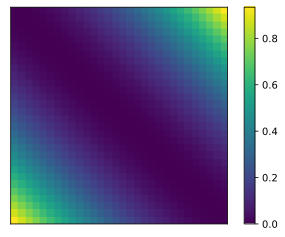

In [4]:
plt.figure()

n = 30
positions = numpy.arange(n) / n
#      ↓ column vector of positions   ↓ row vector of positions
mat = (positions.reshape((-1, 1))   - positions.reshape((1, -1))) ** 2

plt.xticks([])
plt.yticks([])
plt.imshow(mat)
plt.colorbar();

As a result, the DILATE method allows to both better model shape matching than
MSE and better localize shapes than soft-DTW:

```{figure} ../fig/forecasting_le_guen.png
---
width: 100%
name: forecasting_le_guen
---
Comparison between MSE, soft-DTW (denoted $DTW_\gamma$) and DILATE as loss
functions for forecasting tasks.
This Figure is taken from {cite}`vincent2019shape`.
```

## Conclusion

In this part of the course, we have presented similarity measures for time
series that aim to
tackle time shift invariance (a.k.a. temporal localization invariance) and their
use at the core of various machine learning models.

Dynamic Time Warping is probably the most well-known measures among those
presented here.
We have shown how to use it in standard classification models as well as for
$k$-means clustering, in which case a notion of barycenter has to be defined.
We have also presented one of its strongest limitations which is its
non-differentiability, which has led to the introduction of a soft variant
that can hence be used as a loss (for structured prediction settings) in
neural networks.

## References

```{bibliography} ../../references.bib
:filter: docname in docnames
```